ROC panel performance plot created


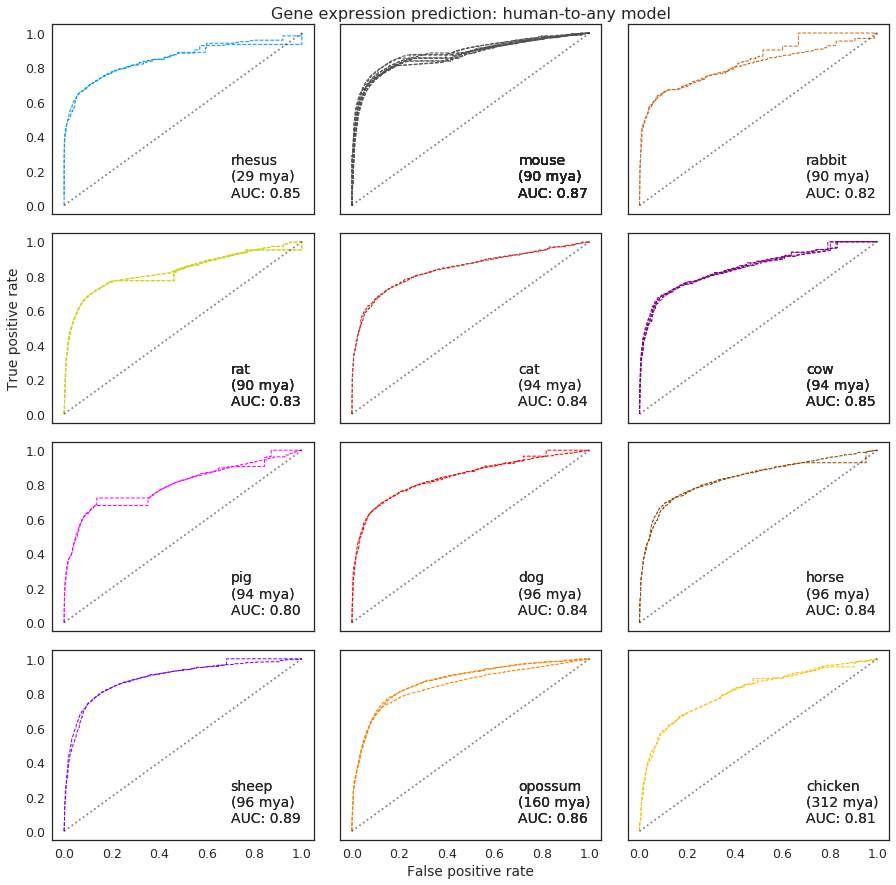

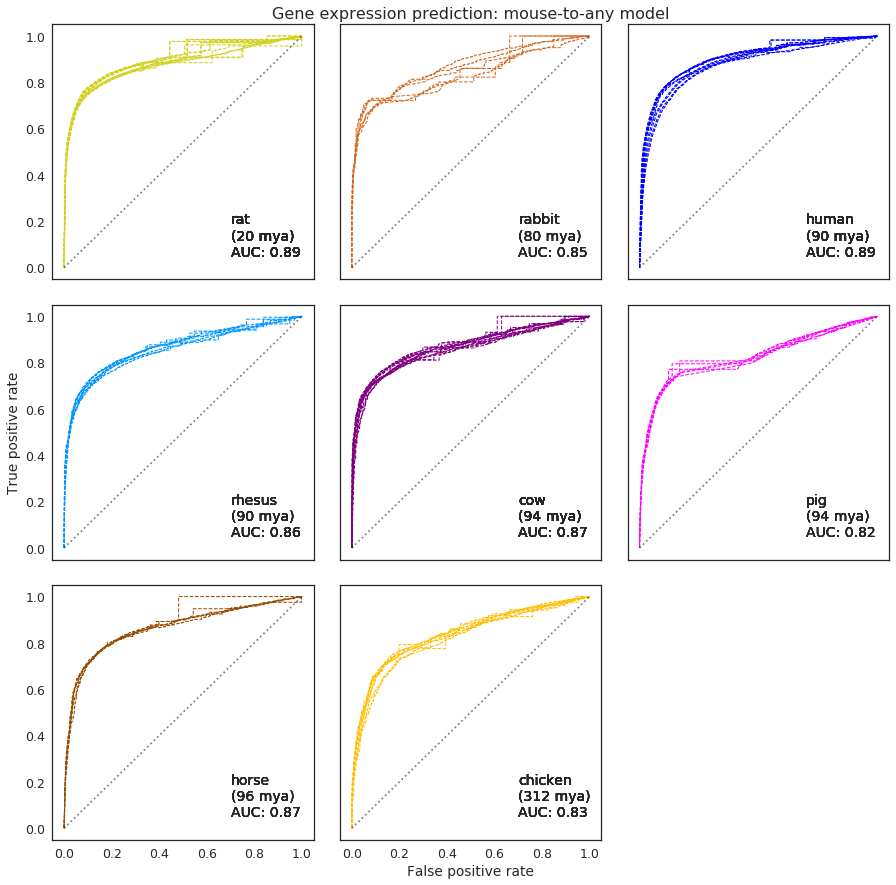

In [14]:
%matplotlib inline

import os as os
import json as js
import csv as csv
import pickle as pck
import collections as col
import operator as op
import functools as fnt
import warnings as warn

import sklearn.exceptions as skle
from sklearn.metrics import auc, roc_auc_score, \
    average_precision_score, precision_recall_curve, roc_curve

warn.filterwarnings('error', message='Precision.+', category=skle.UndefinedMetricWarning)

import pandas as pd
import numpy as np
import numpy.random as rng
from scipy.interpolate import interp1d
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from scipy.stats import mannwhitneyu as mwu

from sklearn.metrics import precision_recall_fscore_support as pfm

date = '20180316'

sns.set(style='white',
        font_scale=1.25,
        rc={'font.family': ['sans-serif'],
            'font.sans-serif': ['DejaVu Sans']})

fhgfs_base = '/TL/deep/fhgfs/projects/pebert/thesis'
stat_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_summarize')
stat_file = os.path.join(stat_folder, 'agg_expstat_est.h5')
ortho_folder = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/task_ortho_pred')
ortho_pred = os.path.join(ortho_folder, 'orthopred_odb_v9.h5')

cache_dir = os.path.join(fhgfs_base, 'projects/cross_species/processing/norm/caching/notebooks')

conf_folder = '/home/pebert/work/code/mpggit/crossspecies/graphics'
ref_folder = '/home/pebert/work/code/mpggit/refdata/annotation'

plot_labels = js.load(open(os.path.join(conf_folder, 'labels', 'cs_labels.json'), 'r'))
plot_colors = js.load(open(os.path.join(conf_folder, 'colors', 'cs_colors.json'), 'r'))
plot_shapes = js.load(open(os.path.join(conf_folder, 'shapes', 'cs_shapes.json'), 'r'))
lca_times_file = os.path.join(ref_folder, 'lca_dist.tsv')
species_file = os.path.join(ref_folder, 'species.tsv')

run_exec_perf_comp = True

show_figures = True

out_folder = '/TL/deep-external01/nobackup/pebert/cloudshare/mpiinf/phd/chapter_projects/crossspecies/figures/pub'
save_figures = True

def exec_status():
    cache_data = os.path.join(cache_dir, '{}_plot_perfcomp_roc.h5'.format(date))
    fullmodel = 'can'
    comparison = 'pos'
    spec_pairs = set()
    if os.path.isfile(cache_data):
        perf_scores = dict()
        with pd.HDFStore(cache_data, 'r') as hdf:
            for k in hdf.keys():
                data = hdf[k]
                _, spec_a, spec_b, values = k.split('/')
                spec_pairs.add((spec_a, spec_b))
                lut_k = spec_a, spec_b, values
                perf_scores[lut_k] = data
                
    else:
        perf_scores = collect_roc_curves(stat_file, fullmodel, comparison)
        temp_scores = dict()
        with pd.HDFStore(cache_data, 'w', complib='blosc', complevel=9) as hdf:
            for key, values in perf_scores.items():
                spec_pairs.add((key[0], key[1]))
                out_path = '/'.join(key)
                if out_path.endswith('auc'):
                    out_obj = pd.Series(values, dtype=np.float32)
                else:
                    out_obj = pd.DataFrame(values, index=list(range(len(values))), dtype=np.float32)
                hdf.put(out_path, out_obj, format='fixed')
                temp_scores[key] = out_obj
        perf_scores = temp_scores
                
    species_info, lca_dist = read_references(species_file, lca_times_file)
        
    for ref_spec in ['human', 'mouse']:
        spec_order = sorted([(p, d) for p, d in lca_dist.items() if p[0] == ref_spec and p in spec_pairs],
                            key=lambda t: (t[1], t[0][1]))
        
        fig, exart = plot_species_comp(perf_scores, spec_order,
                                       species_info, 'Gene expression prediction: {}-to-any model'.format(ref_spec))
        if save_figures:
            if ref_spec == 'human':
                outpath = os.path.join(out_folder, 'main', '{}_fig_2C_main_human_testperf_all.svg'.format(date))
            else:
                outpath = os.path.join(out_folder, 'supp', '{}_fig_X_supp_mouse_testperf_all.svg'.format(date))
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
            outpath = outpath.replace('.svg', '.png')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight', dpi=300)
            outpath = outpath.replace('.png', '.pdf')
            fig.savefig(outpath, bbox_extra_artists=exart, bbox_inches='tight')
    return True


def plot_species_comp(perf_data, spec_order, spec_info, title):
    """
    """
    num_cols = 3
    num_rows = int(np.ceil(len(spec_order) / 3))
    fig, ax = plt.subplots(num_rows, num_cols, figsize=(15, 15),
                           sharex=True, sharey=True)
    extra_artists = []
    
    data_idx = 0
    for row in range(num_rows):
        
        for col in range(num_cols):
            if data_idx >= len(spec_order):
                this_axis = ax[row, col]
                fig.delaxes(this_axis)
                break
            this_data = spec_order[data_idx]
            qry = this_data[0][1]
            split = this_data[1]
            this_axis = ax[row, col]
            this_axis.set_xlim(-0.05, 1.05)
            this_axis.set_ylim(-0.05, 1.05)
            data_idx += 1
            model_auc = perf_data[(this_data[0][0], this_data[0][1], 'auc')]
            model_fpr = perf_data[(this_data[0][0], this_data[0][1], 'fpr')]
            model_tpr = perf_data[(this_data[0][0], this_data[0][1], 'tpr')]
            avg_auc = np.round(model_auc.mean(), 2)
            rgb = spec_info[this_data[0][1]]['color_rgb'].split('-')
            rgb = tuple(map(lambda x: int(x) / 255, rgb))
            for row_idx in range(model_fpr.shape[0]):
                fpr = model_fpr.iloc[row_idx, :]
                fpr.dropna(inplace=True)
                tpr = model_tpr.iloc[row_idx, :]
                tpr.dropna(inplace=True)
                this_axis.plot(fpr, tpr, color=rgb, ls='dashed', lw=1)
                this_axis.text(0.7, 0.05, '{}\n({} mya)\nAUC: {:.2f}'.format(qry, split, avg_auc),
                               fontsize=14)
            # add the main diagonal indicating the performance
            # of the model averaged over 1000 random permutations
            # of the output labels
            this_axis.plot((0, 1), (0, 1),
                           ls='dotted', c='black', alpha=0.5)
    if num_rows == 3:
        xlab_axis = ax[2, 1]
        xlab_axis.set_xlabel('False positive rate')
    else:
        xlab_axis = ax[3, 1]
        xlab_axis.set_xlabel('False positive rate')
        
    ylab_axis = ax[1, 0]
    ylab_axis.set_ylabel('True positive rate')
    
    title_axis = ax[0, 1]
    title_axis.set_title(title, fontsize=16)
       
    plt.subplots_adjust(hspace=0.1, wspace=0.1)
            
#     ax.set_xticks(x_vals)
#     ax.set_xticklabels(x_labels, fontsize=14, rotation=30)
        
#     handles, labels = ax.get_legend_handles_labels()
#     fig_legend = ax.legend(loc=1, fontsize=14)
        
    
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
    return fig, extra_artists


def read_references(species, lca):
    """
    """
    lca_dist = dict()
    with open(lca_times_file, 'r', newline='') as table:
        rows = csv.DictReader(table, delimiter='\t')
        for r in rows:
            if r['timetree-org'] in ['human', 'mouse']:
                src = r['timetree-org']
                for k, v in r.items():
                    if k.startswith('time'):
                        continue
                    lca_dist[(src, k)] = int(v)
            else:
                break
    
    spec_ann = dict()
    with open(species, 'r', newline='') as table:
        rows = csv.DictReader(table, delimiter='\t')
        for r in rows:
            spec_ann[r['common_name']] = r

    return spec_ann, lca_dist
  

def collect_roc_curves(model_file, model_type, comparison):
    print('collecting')
    collect_perf = col.defaultdict(list)
    with pd.HDFStore(model_file, 'r') as model_hdf:
        filter_key = '/{}/{}'.format(comparison, model_type)
        all_keys = list(model_hdf.keys())
        model_keys = [k for k in all_keys if k.startswith(filter_key) and k.endswith('/roc')]
        for mk in model_keys:
            # after update, add check here for perm test scores
            components = mk.split('/')
            ref_spec, qry_spec = components[3], components[4]
            data = model_hdf[mk]
            perf = model_hdf[mk.replace('/roc', '/perf')]
            auc = perf.loc['perf_wg', 'auc_roc']
            
            fpr = data.loc['fpr', :].values
            tpr = data.loc['tpr', :].values           
            
            collect_perf[(ref_spec, qry_spec, 'auc')].append(auc)
            collect_perf[(ref_spec, qry_spec, 'fpr')].append(fpr)
            collect_perf[(ref_spec, qry_spec, 'tpr')].append(tpr)
    return collect_perf


if run_exec_perf_comp:
    execd = exec_status()
    print('ROC panel performance plot created')
